### Import Libraries

In [42]:
import os
import time
import copy
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from IPython.display import Image as ig
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

In [43]:
#checking the image size throhugh the network
def check_size(w, f, p, s):
    wo = (((w-f+2*p)/s )+1)
    return wo

print(check_size(209, 2, 1, 2))

105.5


In [44]:
torch.cuda.empty_cache()

##### Device set to Cuda

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Transforms and Dataloaders

In [46]:
data_transforms = {
    'train': transforms.Compose([
        #Data Augmentation
#         transforms.CenterCrop(size=[416, 416]),
        transforms.Resize([416, 416]),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(45),
        transforms.ToTensor(),              #convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize([416, 416]),
#         transforms.CenterCrop([416, 416]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [47]:
DATA_PATH = './cleandata/'
BATCH_SIZE = 4
#load dataset and apply dataloaders
image_datasets = {x: datasets.ImageFolder(root=os.path.join(DATA_PATH, x), transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in ['train', 'test']}

In [48]:
data_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [49]:
classes = image_datasets['train'].classes
classes

['Pizza', 'Sandwich']

In [51]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  #416
        self.batchNorm1 = nn.BatchNorm2d(num_features=16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 209
        self.leakyRelu = nn.LeakyReLU(0.01)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)   #209                            
        self.batchNorm2 = nn.BatchNorm2d(num_features=32)                                  #105
        #pool
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=1)  #211                             
        self.batchNorm3 = nn.BatchNorm2d(num_features=16)
        #no pool
        
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=128, kernel_size=3, stride=1, padding=1)    #211                           
        self.batchNorm4 = nn.BatchNorm2d(num_features=128)
        #no pool
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=16, kernel_size=1, stride=1, padding=1)     #213                          
        self.batchNorm5 = nn.BatchNorm2d(num_features=16)
        #no pool
        
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=128, kernel_size=3, stride=1, padding=1)      #213 
        self.batchNorm6 = nn.BatchNorm2d(num_features=128)                                                 #
        # pool
        
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=1, stride=1, padding=1)          #215                     
        self.batchNorm7 = nn.BatchNorm2d(num_features=32)
        #no pool
        
        self.conv8 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, stride=1, padding=1)     #215                          
        self.batchNorm8 = nn.BatchNorm2d(num_features=256)
        #no pool
        
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=32, kernel_size=1, stride=1, padding=1)                               
        self.batchNorm9 = nn.BatchNorm2d(num_features=32)
        #no pool
        
        self.conv10 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, stride=1, padding=1)                               
        self.batchNorm10 = nn.BatchNorm2d(num_features=256)
        # pool
        
        self.conv11 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1, stride=1, padding=1)                               
        self.batchNorm11 = nn.BatchNorm2d(num_features=64)
        #no pool
        
        self.conv12 = nn.Conv2d(in_channels=64, out_channels=512, kernel_size=3, stride=1, padding=1)                               
        self.batchNorm12 = nn.BatchNorm2d(num_features=512)
        #no pool
        
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=1, stride=1, padding=1)                               
        self.batchNorm13 = nn.BatchNorm2d(num_features=64)
        #no pool
        
        self.conv14 = nn.Conv2d(in_channels=64, out_channels=512, kernel_size=3, stride=1, padding=1)                               
        self.batchNorm14 = nn.BatchNorm2d(num_features=512)
        #no pool
        
        self.conv15 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1, stride=1, padding=1)                               
        self.batchNorm15 = nn.BatchNorm2d(num_features=128)
        #no pool
        
        self.conv16 = nn.Conv2d(in_channels=128, out_channels=1000, kernel_size=1, stride=1, padding=1)                               
        self.avgPool = nn.AvgPool2d(kernel_size=2, stride=1)
#         softmax
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(36*36*1000, 64)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.leakyRelu(self.batchNorm1(self.conv1(x))))     
        x = self.pool(self.leakyRelu(self.batchNorm2(self.conv2(x))))
        
        x = self.leakyRelu(self.batchNorm3(self.conv3(x)))
        x = self.leakyRelu(self.batchNorm4(self.conv4(x)))
        x = self.leakyRelu(self.batchNorm5(self.conv5(x)))
        x = self.pool(self.leakyRelu(self.batchNorm6(self.conv6(x))))
        
        x = self.leakyRelu(self.batchNorm7(self.conv7(x)))
        x = self.leakyRelu(self.batchNorm8(self.conv8(x)))
        x = self.leakyRelu(self.batchNorm9(self.conv9(x)))
        x = self.pool(self.leakyRelu(self.batchNorm10(self.conv10(x))))
        
        x = self.leakyRelu(self.batchNorm11(self.conv11(x)))
        x = self.leakyRelu(self.batchNorm12(self.conv12(x)))
        x = self.leakyRelu(self.batchNorm13(self.conv13(x)))
        x = self.leakyRelu(self.batchNorm14(self.conv14(x)))
        x = self.leakyRelu(self.batchNorm15(self.conv15(x)))
        x = self.avgPool(self.conv16(x))
        
        # x = nn.Flatten()(x)
        x = torch.flatten(x,1)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

net = Model()

### Training and Testing

In [52]:
class Methods:
    def __init__(self, model, EPOCH, optimizer, criterion):
#          pass
        self.model = model
        self.epochs = EPOCH
        self.optimizer = optimizer
        self.criterion = criterion
        self.val_loss = []
        self.train_loss = []
        self.val_acc = []
        self.train_acc = []
        
    def train_model(self):
        start = time.time()
        for epoch in (range(self.epochs)):  # loop over the dataset multiple times
            print(f'Epoch: {epoch+1}')
            for mode in ['train', 'test']:
                running_loss = 0.0
                running_acc = 0.0
                if mode=='train':
                    self.model.train(True)
                else:
                    self.model.train(False)
                for i, data in tqdm(enumerate(dataloaders[mode], 0), total=2534):
                    # get the inputs; data is a list of [inputs, labels]
                    
                    inputs, labels = data
                    #transfer the inputs, labels to GPU 
                    inputs = inputs.float()
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients every mini batches/ reset the gradients of model parameters
                    self.optimizer.zero_grad()
                    # forward pass
                    outputs = self.model(inputs)
                    #loss calculation
                    loss = self.criterion(outputs, labels)
                    # print(outputs, labels)
                    if mode=='train':
                        #backward pass/deposits the gradients of the loss w.r.t. each parameter
                        loss.backward()
                        #optimize and update the params
                        self.optimizer.step()
                    # print statistics
                    running_loss += loss.item()
                    #for Accuracy
                    # outputs = torch.log_softmax(outputs, dim=1)
                    # max_vals, max_idx = torch.max(outputs, 1)
                    max_idx = torch.argmax(outputs, 1)
                    check = torch.sum(max_idx==labels)
                    running_acc += check
                if mode=='train':
                    print(f'Training Loss: {running_loss:.3f} | Training Accuracy: {(100*running_acc/data_sizes[mode]):.2f}%')
                    self.train_acc.append(running_acc)
                    self.train_loss.append(running_loss)
                else:
                    print(f'Validation Loss: {running_loss:.3f} | Valaidation Accuracy: {(100*running_acc/data_sizes[mode]):.2f}%')
                    self.val_acc.append(running_acc)
                    self.val_loss.append(running_loss)
            print(f'----------------------------------------------')
            print(f'----------------------------------------------')
        end = time.time()
        training_time = end - start
        print(f'Training Completed in: {training_time//60} min {training_time%60:.2f} sec')
        print('Finished Training...!!!')
        return self.model
    
    #plot loss and accuracy:
    def plot_acc(self):
        epoch = [i for i in range(self.epochs)]
        plt.plot(epoch, self.val_acc, epoch, self.train_acc)
        return 
        
    #test single image
    def testImage(self, PATH):
        if self.model==None:
            print('First, train the model. 🙂')
            return
        self.model.eval()
        image = Image.open(PATH)
        # Define a transform to convert the image to tensor
        transform = data_transforms['test']
        # Convert the image to PyTorch tensor
        img_tensor = transform(image)
        #adding one dimension [1*3*416*416]
        img_tensor = torch.unsqueeze(img_tensor, 0)
        #moved to GPU
        self.model.to(device)
        #moved to Tensor and GPU
        img_tensor = img_tensor.to(device)
        img_tensor = img_tensor.float()
        pred = self.model(img_tensor)
        #get maximum index value
        idx = torch.argmax(pred, dim=1)
        return pred.data*100, classes[idx]

### Hyperparam

In [18]:
LEARNING_RATE = 0.0001
MOMENTUM = 0.9

### Epoch


In [19]:
EPOCH = 5

In [55]:
net = net.to(device)

### Optimizer and Loss 

In [56]:
criterion = nn.CrossEntropyLoss()
#Adagrad
# optimizer = optim.Adagrad(net.parameters(), lr=LEARNING_RATE)
#sgd                          
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

### Train the network

In [57]:
method = Methods(net, EPOCH, optimizer, criterion)

In [58]:
trained_model = method.train_model()

Epoch: 1


  0%|          | 0/2534 [00:00<?, ?it/s]

Training Loss: 1208.726 | Training Accuracy: 82.95%


  0%|          | 0/2534 [00:00<?, ?it/s]

Validation Loss: 77.036 | Valaidation Accuracy: 82.66%
----------------------------------------------
----------------------------------------------
Epoch: 2


  0%|          | 0/2534 [00:00<?, ?it/s]

Training Loss: 1188.049 | Training Accuracy: 83.84%


  0%|          | 0/2534 [00:00<?, ?it/s]

Validation Loss: 75.884 | Valaidation Accuracy: 82.34%
----------------------------------------------
----------------------------------------------
Epoch: 3


  0%|          | 0/2534 [00:00<?, ?it/s]

Training Loss: 1178.256 | Training Accuracy: 84.21%


  0%|          | 0/2534 [00:00<?, ?it/s]

Validation Loss: 76.641 | Valaidation Accuracy: 82.03%
----------------------------------------------
----------------------------------------------
Epoch: 4


  0%|          | 0/2534 [00:00<?, ?it/s]

Training Loss: 1158.802 | Training Accuracy: 84.97%


  0%|          | 0/2534 [00:00<?, ?it/s]

Validation Loss: 72.207 | Valaidation Accuracy: 85.94%
----------------------------------------------
----------------------------------------------
Epoch: 5


  0%|          | 0/2534 [00:00<?, ?it/s]

Training Loss: 1132.866 | Training Accuracy: 86.09%


  0%|          | 0/2534 [00:00<?, ?it/s]

Validation Loss: 72.866 | Valaidation Accuracy: 85.62%
----------------------------------------------
----------------------------------------------
Training Completed in: 59.0 min 38.77 sec
Finished Training...!!!


### Save the model

In [60]:
FILE_PATH = 'model3_dropout_augentation2.pth'
torch.save(trained_model.state_dict(), FILE_PATH)

### Load the model

In [88]:
#name of the model is net
FILE_PATH = 'model3_dropout_augentation2.pth'

net.load_state_dict(torch.load(FILE_PATH))

<All keys matched successfully>

### Testing single image

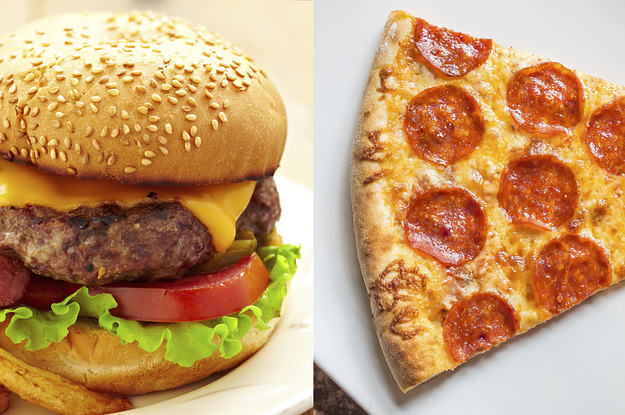

In [83]:
IMG_PATH = "./images/mixed3jpg.jpg"
ig(IMG_PATH, height=200, width=200)


In [84]:
def test_single_image(model, PATH):
    model.eval()
    image = Image.open(PATH)
    # Define a transform to convert the image to tensor
    transform = data_transforms['test']
    # Convert the image to PyTorch tensor
    img_tensor = transform(image)
    #adding one dimension [1*3*416*416]
    img_tensor = torch.unsqueeze(img_tensor, 0)
    #moved to GPU
    model.to(device)
    #moved to Tensor and GPU
    img_tensor = img_tensor.to(device)
    img_tensor = img_tensor.float()
    pred = model(img_tensor)
    #get maximum index value
    # vals, idx = torch.max(pred, dim=1)
    idx = torch.argmax(pred, dim=1)
    return pred.data*100, idx

In [85]:
score, predicted = test_single_image(net, IMG_PATH)

In [86]:
print(f"Predicted '{classes[predicted]}' with a score of {score[0][predicted][0]}")

Predicted 'Pizza' with a score of 68.24231719970703


In [ ]:
#without dropoyt and augmentation lr=0.001, m=0.9
# Training Loss: 266.867 Training Accuracy: 77.00%
# Validation Loss: 7.103 Valaidation Accuracy: 65.91%
# ---------------------------------------------------
#with dropout and augementation lr=0.001
# model3_dropout_augentation.pth
# Training Loss: 213.283 | Training Accuracy: 88.02%
# Validation Loss: 6.249 | Valaidation Accuracy: 72.73%
# ---------------------------------------------------
# lr=10e-4
# Training Loss: 246.011 | Training Accuracy: 80.13%
# Validation Loss: 12.536 | Valaidation Accuracy: 70.45%

#10epochs
# Training Loss: 465.960 | Training Accuracy: 96.45%
# Validation Loss: 15.438 | Valaidation Accuracy: 99.47%
#results: predicting everything pizza 

